# Test annealing performance with cross validation

In [1]:
import uproot
np.set_printoptions(precision=3, suppress=True, linewidth=500)

# The ROOT file to split
source_file = "./data/tau_pipi0_BGx1.root"
# The tree name where the data is stored in the source_file
source_tree_name = "tau"

nbins, binmin, binmax = 50, 0.2, 1.8

In [2]:
cache = uproot.LRUArrayCache("1 GB")
array = uproot.lazy(f"{source_file}:{source_tree_name}", step_size="1 GB", array_cache=cache)

In [22]:
import boost_histogram as bh

def compute_response_matrix(data, nbins, binmin, binmax):
    # Create the response matrix as a 2D histogram
    R = bh.Histogram(
        bh.axis.Regular(bins=nbins, start=binmin, stop=binmax),
        bh.axis.Regular(bins=nbins, start=binmin, stop=binmax))
    # Fill the histogram
    truth = data.tau_0_matchedMC_InvM
    detected = data.tau_0_InvM
    R.fill(detected, truth)
    return R

def get_histogram(data, nbins, binmin, binmax):
    histogram = bh.Histogram(bh.axis.Regular(bins=nbins, start=binmin, stop=binmax))
    histogram.fill(data)
    return histogram

In [30]:
from sklearn.model_selection import ShuffleSplit
import numpy as np
from utils.stats import compute_numpy_covariance_matrix
# Unfolding libraries
from unfolders.unfolder import Unfolder
from unfolders.annealing import (
    SimulatedAnnealingBackend,
    SimulatedQuantumAnnealingBackend,
)

results = []

# Perform n_splits iterations to test the spread of the annealing results
splitter = ShuffleSplit(n_splits=5, test_size=0.5)
for train_index, test_index in splitter.split(array):
    train_set = array[train_index]
    test_set = array[test_index]
    # Get variabels from the training set and compute response matrix
    xini = get_histogram(train_set.tau_0_matchedMC_InvM, nbins, binmin, binmax)
    bini = get_histogram(train_set.tau_0_InvM, nbins, binmin, binmax)
    R = compute_response_matrix(train_set, nbins, binmin, binmax)
    # To probabilities
    xini_numpy = xini.to_numpy()[0]
    R_numpy = R.to_numpy()[0]
    R_probabilities = np.where(xini_numpy > 0, np.divide(R_numpy, xini_numpy), 0)
    # Get the "measured" invariant mass and the truth
    truth = get_histogram(test_set.tau_0_matchedMC_InvM, nbins, binmin, binmax)
    data  = get_histogram(test_set.tau_0_InvM, nbins, binmin, binmax)
    statcov = compute_numpy_covariance_matrix(data)
    # Perform unfolding
    backend = SimulatedAnnealingBackend(4, 100, weight_regularization=0.7)
    unfolder = Unfolder(data.to_numpy()[0], statcov, xini.to_numpy()[0], bini.to_numpy()[0], R_probabilities)
    result = unfolder.unfold(backend)
    results.append(result)
    print("Done")

<ipython-input-30-2a5f598fdbc8>:25: RuntimeWarning: invalid value encountered in true_divide
  R_probabilities = np.where(xini_numpy > 0, np.divide(R_numpy, xini_numpy), 0)
num reads: 100
Done
num reads: 100
Done
num reads: 100
Done
num reads: 100
Done
num reads: 100
Done


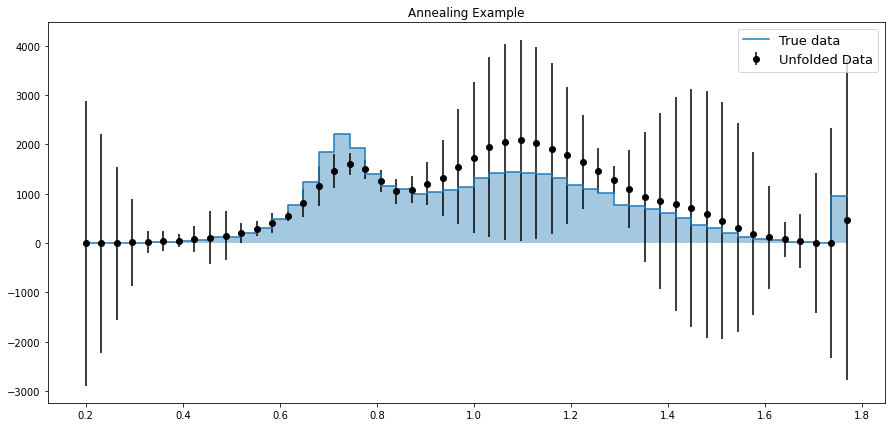

In [31]:
import pylab as plt

# Plot the result
axis = xini.to_numpy()[1][:-1]
plt.figure(figsize=(15, 7))
# Plot the original distribution
plt.step(axis, truth, fillstyle="bottom", label="True data")
plt.fill_between(axis, truth, step="pre", alpha=0.4)
# Plot the unfolded
plt.errorbar(
    axis,
    result.solution,
    yerr=result.error,
    fmt="o",
    color="black",
    label="Unfolded Data",
)
plt.legend(prop={"size": 13})
plt.title("Annealing Example")
plt.show()

In [27]:
np.set_printoptions(precision=3, suppress=True, linewidth=500)
R_probabilities

array([[  nan,   nan, 0.   , ..., 0.   , 0.   , 0.001],
       [  nan,   nan, 1.   , ..., 0.   , 0.   , 0.012],
       [  nan,   nan, 0.   , ..., 0.   , 0.   , 0.042],
       ...,
       [  nan,   nan, 0.   , ..., 0.   , 0.   , 0.   ],
       [  nan,   nan, 0.   , ..., 0.   , 0.   , 0.   ],
       [  nan,   nan, 0.   , ..., 0.   , 0.   , 0.   ]])